# Demography

**Georgia Tsambos**

So far, we've been simulating samples from a single population of a constant size,
which isn't particularly exciting!
One of the strengths of msprime is that it can be used to specify quite complicated
models of demography and population history with a simple Python API.

In [1]:
%config InlineBackend.figure_format = 'svg'
import msprime
import numpy as np
from IPython.display import SVG

## Population structure

``msprime`` supports simulation from multiple discrete populations,
each of which is initialized with a {class}`msprime.Population` object.
For each population, you can specify a sample size, an effective population size
at time = 0, an exponential growth rate and a name.

*Note: Population structure in ``msprime`` closely follows the model used in the
``ms`` simulator.
Unlike ``ms`` however, all times and rates are specified
in generations and all populations sizes are absolute (that is, not
multiples of :math:`N_e`).*

Suppose we wanted to simulate three sequences each from two populations
with a constant effective population size of 500.

In [2]:
pop0 = msprime.Population(initial_size=500, growth_rate=0, name='Population0')
pop1 = msprime.Population(initial_size=500, growth_rate=0, name='Population1')
samples0 = msprime.SampleSet(num_samples=3, population='Population0')
samples1 = msprime.SampleSet(num_samples=3, population='Population1')

You can give these to your {class}`msprime.Demography` object as a list
using the ``populations`` argument.
(Note that we no longer need to specify ``Ne`` as we have provided a separate size for each population).

In [3]:
# dem = msprime.Demography(populations=[pop0, pop1])
# ts = msprime.sim_ancestry(samples=[samples0, samples1], demography=dem, random-seed=12, sequence_length=1000, recombination_rate=1e-4)

However, **this simulation will run forever** unless we also
specify some migration between the groups!
To understand why, recall that ``msprime`` is a `coalescent`-based simulator.
The simulation will run backwards-in-time, simulating until `all` samples have
coalesced to a single common ancestor at each genomic location.
However, with no migration between our two populations, samples in one
population will never coalesce with samples in another population.
To fix this, let's add some migration events to the specific demographic history.

## Migrations

With msprime, you can specify continual rates of migrations between
populations, as well as one-off mass migrations.

### Constant migration

![constant-migration-diagram](_static/tute-population-structure-1.png)

Migration rates between the populations can be specified as the elements of an
*N* by *N* numpy array, and given to {func}`msprime.sim_ancestry` via the
``migration_matrix`` argument. The diagonal elements of this array must each be
0, and the *(i, j)* th element specifies the expected number of migrants moving
from population *j* to population *i* per generation, divided by the size of
population *i*.  When this rate is small (close to 0), it is approximately
equal to the fraction of population *i* that consists of new migrants from
population *j* in each generation.

For instance, the following migration matrix specifies that in each generation,
approximately 5% of population 0 consists of migrants from population 1, and
approximately 2% of population 1 consists of migrants from population 0.

In [4]:
M = np.array([
[0, 0.05],
[0.02, 0]])
dem = msprime.Demography(populations=[pop0, pop1], migration_matrix=M)
ts = msprime.sim_ancestry(samples=[samples0, samples1], demography=dem, sequence_length=1000, random_seed=17, recombination_rate=1e-7)

One consequence of specifying :class:`msprime.Population` objects
is that each of the simulated nodes will now belong to one of our specified
populations:

In [5]:
print(ts.tables.nodes)

id	flags	population	individual	time	metadata
0	1	0	0	0.00000000000000	
1	1	0	0	0.00000000000000	
2	1	0	1	0.00000000000000	
3	1	0	1	0.00000000000000	
4	1	0	2	0.00000000000000	
5	1	0	2	0.00000000000000	
6	1	1	3	0.00000000000000	
7	1	1	3	0.00000000000000	
8	1	1	4	0.00000000000000	
9	1	1	4	0.00000000000000	
10	1	1	5	0.00000000000000	
11	1	1	5	0.00000000000000	
12	0	1	-1	32.20268342300078	
13	0	1	-1	136.19260203027568	
14	0	1	-1	144.81604777490708	
15	0	1	-1	223.73159373890010	
16	0	1	-1	241.03586279244348	
17	0	1	-1	576.60049955856971	
18	0	1	-1	594.92491484951927	
19	0	1	-1	1004.22381530940197	
20	0	1	-1	1011.61229375302696	
21	0	1	-1	1132.03556587555613	
22	0	1	-1	1156.96427328450591	
23	0	1	-1	2723.42407534135509	


Notice that the ``population`` column of the node table now contains values of 0 and 1.
If you are working in a Jupyter notebook, you can draw the tree sequence
with nodes coloured by population label using SVG:

Tree on interval: Interval(left=0.0, right=494.0)


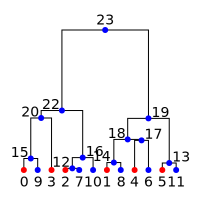

Tree on interval: Interval(left=494.0, right=1000.0)


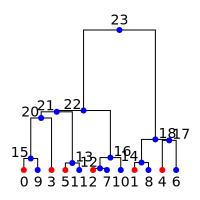

In [6]:
colour_map = {0:"red", 1:"blue"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}
for tree in ts.trees():
    print("Tree on interval:", tree.interval)
    # The code below will only work in a Jupyter notebook with SVG output enabled.
    display(SVG(tree.draw(node_colours=node_colours)))

More coalescences are happening in population 1 than population 0.
This makes sense given that population 1 is specifying more migrants to
population 0 than vice versa.

### Changing migration rates

We can change any of the migration rates at any time in the simulation.
To do this, we just need to add a {class}`msprime.MigrationRateChange` object
specifying the index of the migration matrix to be changed,
the time of the change and the new migration rate.

For instance, say we wanted to specify that in each generation prior to
time = 100, 1% of population 0 consisted of migrants from population 1.

In [7]:
migration_rate_change = msprime.MigrationRateChange(time = 100, rate = 0.01, source=0, dest=1)

A list of these changes can be supplied to {func}`msprime.sim_ancestry` via the
``demographic_events`` input:
(If there is more than 1 change, ensure they are ordered by backwards-time!)

In [8]:
dem = msprime.Demography(populations=[pop0, pop1], migration_matrix=M, events=[migration_rate_change])
ts = msprime.sim_ancestry(samples=[samples0, samples1], demography=dem, sequence_length=1000, random_seed=63461, recombination_rate=1e-7)

### Mass migrations

:class:`msprime.MassMigration` objects are used to specify one-off events in which some fraction of a population moves into another population. These are useful for specifying divergence and admixture events.

![](_static/tute-mass-migration.png)

You'll need to provide the time of the event in generations,
the ID of the source and destination populations,
and a migration proportion (which defaults to 1.0).
For example, the following specifies that 50 generations ago,
30% of population 0 was a migrant from population 1.

In [9]:
admixture_event  = msprime.MassMigration(time = 50, source = 0, dest = 1, proportion = 0.3)

Note that these are viewed as backwards-in-time events,
so ``source`` is the population that receives migrants from ``dest``.

Any mass migrations can be added into the list of ``events`` supplied to {func}`msprime.sim_ancestry` via the {class}`msprime.Demography` object.

In [10]:
dem = msprime.Demography(populations=[pop0, pop1], migration_matrix=M, events=[admixture_event])
ts = msprime.sim_ancestry(samples=[samples0, samples1], demography=dem, sequence_length=1000, random_seed=63461, recombination_rate=1e-7)

{class}`msprime.MassMigration` objects can also be used to specify divergence events, but we must take some care.

![](_static/tute-divergence-1.png)

The following specifies that 200 generations ago, 100% of population 1 was a migrant from population 0.

In [11]:
divergence_event = msprime.MassMigration(
        time = 200, source = 1, dest = 0, proportion = 1)

We'll add this to our list of ``events`` in our {class}`msprime.Demography` object.

In [12]:
dem = msprime.Demography(populations=[pop0, pop1], migration_matrix=M, events=[admixture_event, divergence_event])
ts = msprime.sim_ancestry(samples=[samples0, samples1], demography=dem, sequence_length=1000, random_seed=63461, recombination_rate=1e-7)

However, when we look at the population IDs corresponding to the the nodes from more than 200 generations ago, there are still some nodes from both populations. This is not what what we'd expect to see if we'd correctly simulated a divergence event!

In [13]:
[u.population for u in ts.nodes() if u.time > 200]

[1, 1, 1, 1, 0]

The reason is that at present, we are simulating a situation in which population 1 exists prior to generation 200, but is completely replaced by migrants from population 0 at time = 200. And because we've specified a migration matrix, there will still be some migrants from population 0 to population 1 in prior generations.

![](_static/tute-divergence-2.png)

We can fix this by also specifying that prior to time = 200, population 1 had no migration from population 0.

In [14]:
rate_change = msprime.MigrationRateChange(time = 200, rate = 0, matrix_index=None)
dem = msprime.Demography(populations=[pop0, pop1], migration_matrix=M, events=[admixture_event, divergence_event, rate_change])
ts = msprime.sim_ancestry(samples=[samples0, samples1], demography=dem, sequence_length=1000, random_seed=63461, recombination_rate=1e-7)

Now all ancestral nodes prior to generation 200 are exclusively from population 0. Hooray!

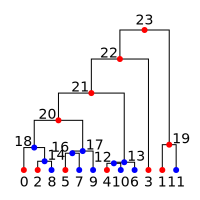

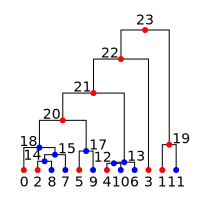

In [15]:
[u.population for u in ts.nodes() if u.time > 200]

# This only works in a Jupyter notebook.
from IPython.display import SVG

colour_map = {0:"red", 1:"blue"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}
for tree in ts.trees():
    display(SVG(tree.draw(node_colours=node_colours)))

## Changing population sizes or growth rates

![](_static/tute-parameter-changes.png)

We may wish to specify changes to rates of population growth,
or sudden changes in population size at a particular time.
Both of these can be specified with {class}`msprime.PopulationParametersChange`
objects in the supplied list of ``events``.

In [16]:
# Bottleneck in Population 0 between 50 - 150 generations ago.
pop0_bottleneck_ends = msprime.PopulationParametersChange(
    time = 50, initial_size = 250, population = 0)
pop0_bottleneck_starts = msprime.PopulationParametersChange(
    time = 150, initial_size = 500, population = 0)

# Exponential growth in Population 1 starting 50 generations ago.
pop1_growth = msprime.PopulationParametersChange(
    time = 100, growth_rate = 0.01, population = 1)

dem = msprime.Demography(populations=[pop0, pop1], migration_matrix=M, events=[pop0_bottleneck_ends, pop1_growth, pop0_bottleneck_starts])
ts = msprime.sim_ancestry(samples=[samples0, samples1], demography=dem, sequence_length=1000, random_seed=63461, recombination_rate=1e-7)

Note that because ``msprime`` simulates backwards-in-time, parameter changes must be
interpreted backwards-in-time as well.
For instance, the ``pop1_growth`` event in the example above
specifies continual growth in the early history of population 1 up until 100
generations in the past.


## Debugging demography

As we've seen, it's pretty easy to make mistakes when specifying demography!

To help you spot these, msprime provides a debugger that prints out your
population history in a more human-readable form.
It's good to get into the habit of running the {class}`msprime.DemographyDebugger`
before running your simulations.

In [17]:
my_history = msprime.DemographyDebugger(demography=dem)
my_history.print_history()

Epoch: 0 -- 50.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |   500      500                0 |     0      0.05   
1 |   500      500                0 |   0.02       0    

Events @ generation 50.0
   - Population parameter change: population=0: initial_size → 250
Epoch: 50.0 -- 100.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |   250      250                0 |     0      0.05   
1 |   500      500                0 |   0.02       0    

Events @ generation 100.0
   - Population parameter change: population=1: growth_rate → 0.01
Epoch: 100.0 -- 150.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |   250      250                0 |     0      0.05   
1 |   500      303             0.01 |   0.02       0    

Events @ generation 150.0
   - P